In [ ]:
!pip install tensorflow==2.6.0
import tensorflow as tf
print(tf.__version__)

In [ ]:
!pip install tensorflow==2.6.0 keras==2.6.0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import metrics
import tensorflow as tf
from tensorflow.keras.models import load_model

# 데이터 경로
train_dir = '/content/drive/MyDrive/testdata_num_renamed/train'
val_dir = '/content/drive/MyDrive/testdata_num_renamed/val'

# 이미지 크기 및 채널
img_size = (224, 224)
img_channel = 3

# 이미지 데이터 전처리
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    brightness_range=(0.8,1.8),
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

# 저장된 모델 불러오기
model = load_model('/content/drive/MyDrive/ResNet101_All_data2_1frame.h5')

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])

# 스케줄러 함수 정의
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# 학습률 스케줄링 콜백 설정
lr_scheduler = LearningRateScheduler(scheduler)

# 체크포인트를 저장할 경로
checkpoint_filepath = '/content/drive/MyDrive/checkpoint/checkpoints/model-{epoch:03d}.h5'

# 체크포인트 콜백 설정
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True, # 가장 성능이 좋은 가중치 저장 여부
    save_weights_only=True, # 모델, 가중치 저장 선택
    verbose=1)

# 조기 종료 콜백 설정
#early_stopping_callback = EarlyStopping(
#    monitor='val_loss',
#    patience=5, # val_loss가 최소 5 epoch 동안 개선되지 않으면 학습 중단
#    restore_best_weights=True) # 가장 성능이 좋은 가중치 복원 여부

# 모델 학습
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=30,
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          callbacks=[checkpoint_callback, lr_scheduler]) # 체크포인트, 조기 종료 인자 추가

Found 2077 images belonging to 16 classes.
Found 537 images belonging to 16 classes.
Epoch 1/30
130/130 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.9355 - precision: 0.9417 - recall: 0.9326
Epoch 1: val_loss improved from inf to 0.35628, saving model to /content/drive/MyDrive/checkpoint/checkpoints/model-001.h5
130/130 [==============================] - 1447s 11s/step - loss: 0.2615 - accuracy: 0.9355 - precision: 0.9417 - recall: 0.9326 - val_loss: 0.3563 - val_accuracy: 0.8603 - val_precision: 0.8652 - val_recall: 0.8603 - lr: 0.0010
Epoch 2/30
130/130 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9798 - precision: 0.9807 - recall: 0.9783
Epoch 2: val_loss improved from 0.35628 to 0.14948, saving model to /content/drive/MyDrive/checkpoint/checkpoints/model-002.h5
130/130 [==============================] - 94s 725ms/step - loss: 0.0707 - accuracy: 0.9798 - precision: 0.9807 - recall: 0.9783 - val_loss: 0.1495 - val_accuracy: 0.9348

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/val'

img_size = (224, 224)
img_channel = 3

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    brightness_range=(0.8,1.8),
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

resnet = ResNet50(input_shape=(img_size[0], img_size[1], img_channel), weights=None, include_top=False) # 가중치 체크포인트 파일을 불러오므로 None으로 설정

x = resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(16, activation='softmax')(x) # 클래스 개수만큼 조정

model = models.Model(inputs=resnet.input, outputs=predictions)

# 이전에 저장된 모델 가중치 불러오기
model.load_weights('/content/drive/MyDrive/checkpoints/model-029.h5') # 경로 작성

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/content/drive/MyDrive/checkpoints2-1/model-{epoch:03d}.h5'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

# 학습 이어서 시작
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=30,
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          callbacks=[checkpoint_callback, early_stopping_callback],
          initial_epoch=29) # initial_epoch = 이전에 중단된 epoch 숫자

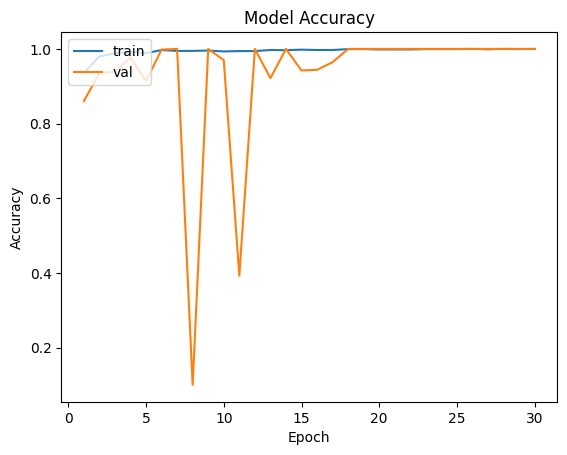

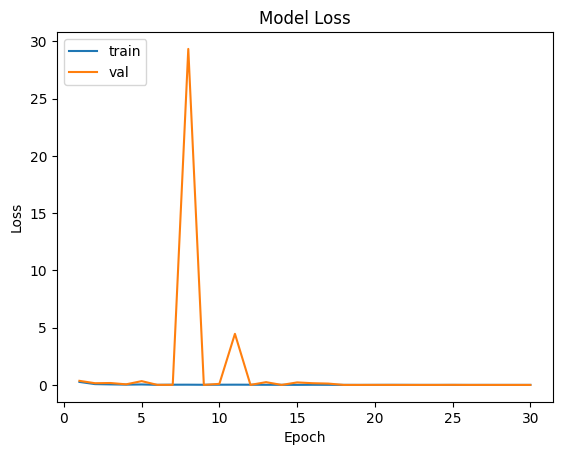

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 곡선 그리기
num_epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, num_epochs + 1)

plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

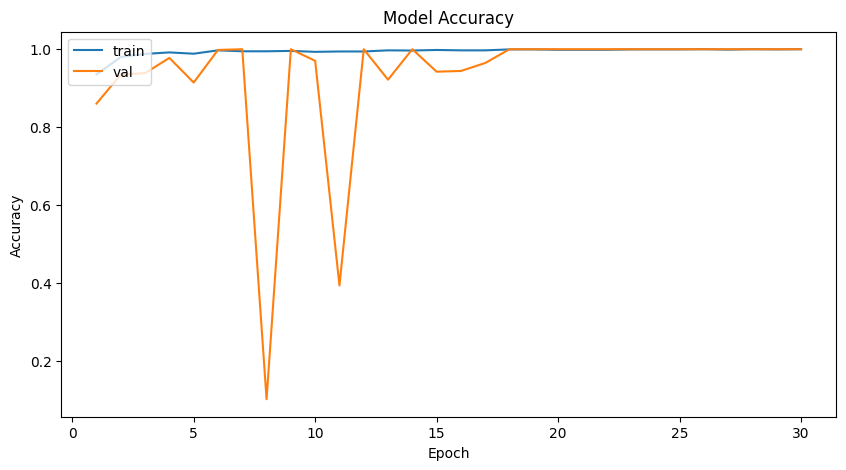

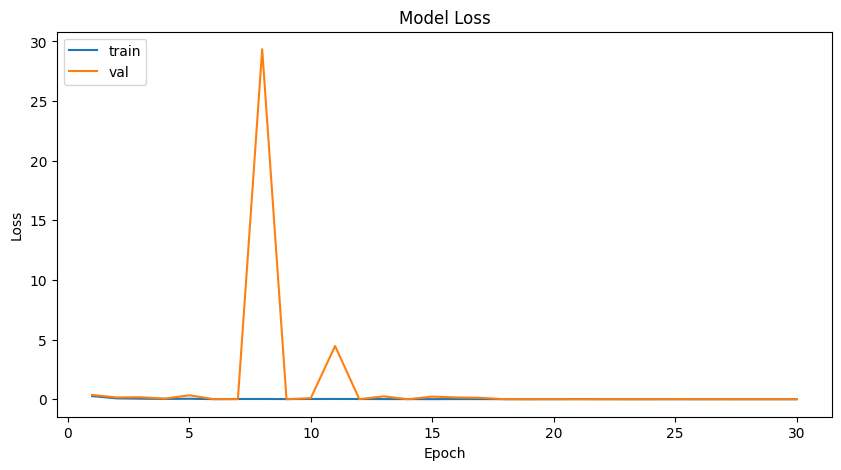

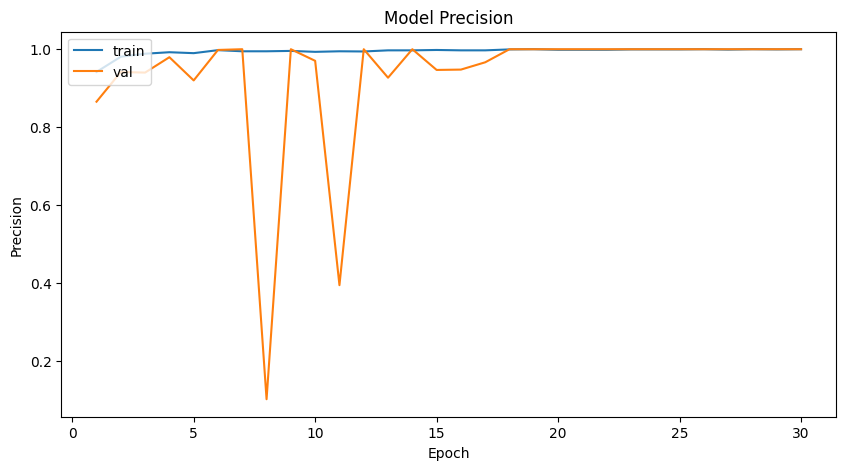

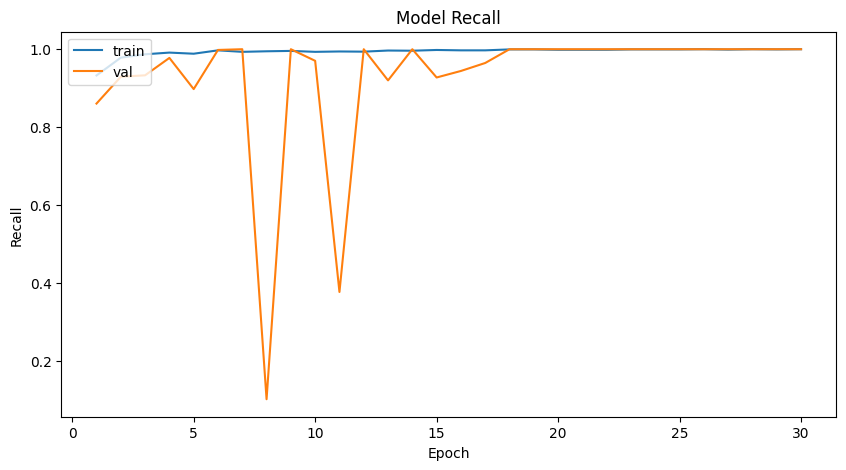

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 곡선 그리기
num_epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['precision'])
plt.plot(epoch_range, history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['recall'])
plt.plot(epoch_range, history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# 구글 드라이브에 모델 저장
model.save('/content/drive/MyDrive/ResNet101_All_A_B_C.h5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 전체 데이터 세트 중 테스트 데이터 폴더 경로
test_dir = '/content/drive/MyDrive/data_all/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet101_All_A_B_C.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

Found 2611 images belonging to 16 classes.
2611/2611 [==============================] - 1453s 553ms/step
테스트 결과
---------------------
back_left/back_left103.jpg : back_left_left
back_left/back_left1182.jpg : back_left
back_left/back_left1183.jpg : back_left
back_left/back_left1184.jpg : back_left
back_left/back_left1185.jpg : back_left
back_left/back_left1186.jpg : back_left
back_left/back_left1187.jpg : back_left
back_left/back_left1188.jpg : back_left
back_left/back_left1189.jpg : back_left
back_left/back_left1190.jpg : back_left
back_left/back_left1191.jpg : back_left
back_left/back_left1192.jpg : back_left
back_left/back_left1193.jpg : back_left
back_left/back_left1194.jpg : back_left
back_left/back_left1195.jpg : back_left
back_left/back_left1196.jpg : back_left
back_left/back_left1197.jpg : back_left
back_left/back_left1198.jpg : back_left
back_left/back_left1199.jpg : back_left
back_left/back_left120.jpg : back_left_left
back_left/back_left1200.jpg : back_left
back_left/back_lef

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 4월에 새로 찍은 전체 데이터 세트 중 테스트 데이터 폴더 경로
test_dir = '/content/drive/MyDrive/data2_1frame_num_renamed/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet101_All_A_B_C.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

Found 1015 images belonging to 16 classes.
1015/1015 [==============================] - 559s 549ms/step
테스트 결과
---------------------
back_left/back_left1182.jpg : back_left
back_left/back_left1183.jpg : back_left
back_left/back_left1184.jpg : back_left
back_left/back_left1185.jpg : back_left
back_left/back_left1186.jpg : back_left
back_left/back_left1187.jpg : back_left
back_left/back_left1188.jpg : back_left
back_left/back_left1189.jpg : back_left
back_left/back_left1190.jpg : back_left
back_left/back_left1191.jpg : back_left
back_left/back_left1192.jpg : back_left
back_left/back_left1193.jpg : back_left
back_left/back_left1194.jpg : back_left
back_left/back_left1195.jpg : back_left
back_left/back_left1196.jpg : back_left
back_left/back_left1197.jpg : back_left
back_left/back_left1198.jpg : back_left
back_left/back_left1199.jpg : back_left
back_left/back_left1200.jpg : back_left
back_left/back_left1201.jpg : back_left
back_left/back_left1202.jpg : back_left
back_left/back_left1203.jpg

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 4월에 찍은 테스트 데이터의 테스트 데이터 폴더 경로
test_dir = '/content/drive/MyDrive/testdata_num_renamed/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet101_All_A_B_C.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

Found 295 images belonging to 16 classes.
295/295 [==============================] - 160s 539ms/step
테스트 결과
---------------------
back_left/back_left1248.jpg : back_left
back_left/back_left1252.jpg : back_left
back_left/back_left1262.jpg : back_left
back_left/back_left1263.jpg : back_left
back_left/back_left1268.jpg : back_left
back_left/back_left1269.jpg : back_left
back_left/back_left1274.jpg : back_left
back_left/back_left1288.jpg : back_left
back_left/back_left1304.jpg : back_left
back_left/back_left1308.jpg : back_left
back_left/back_left1337.jpg : back_left
back_left/back_left1350.jpg : back_left
back_left/back_left1357.jpg : back_left
back_left/back_left1360.jpg : back_left
back_left/back_left1361.jpg : back_left
back_left/back_left1376.jpg : back_left
back_left/back_left1381.jpg : back_left
back_left/back_left1385.jpg : back_left
back_left/back_left1388.jpg : back_left
back_left/back_left1412.jpg : back_left
back_left_hurray/back_left_hurray1253.jpg : back_left_hurray
back_left

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 4월에 찍은 테스트 데이터 전체 폴더 경로
test_dir = '/content/drive/MyDrive/testdata'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet101_All_A_B_C.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

Found 2909 images belonging to 16 classes.
2909/2909 [==============================] - 1396s 479ms/step
테스트 결과
---------------------
back_left/back_left0.jpg : back_left
back_left/back_left1.jpg : back_left
back_left/back_left10.jpg : back_left
back_left/back_left100.jpg : back_left
back_left/back_left101.jpg : back_left
back_left/back_left102.jpg : back_left
back_left/back_left103.jpg : back_left
back_left/back_left104.jpg : back_left
back_left/back_left105.jpg : back_left
back_left/back_left106.jpg : back_left
back_left/back_left107.jpg : back_left
back_left/back_left108.jpg : back_left
back_left/back_left109.jpg : back_left
back_left/back_left11.jpg : back_left
back_left/back_left110.jpg : back_left
back_left/back_left111.jpg : back_left
back_left/back_left112.jpg : back_left
back_left/back_left113.jpg : back_left
back_left/back_left114.jpg : back_left
back_left/back_left115.jpg : back_left
back_left/back_left116.jpg : back_left
back_left/back_left117.jpg : back_left
back_left/back

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 3월에 찍은 전체 데이터 세트 중 테스트 데이터 폴더 경로
test_dir = '/content/drive/MyDrive/dataset/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet101_All_A_B_C.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

Found 1301 images belonging to 16 classes.
1301/1301 [==============================] - 828s 636ms/step
테스트 결과
---------------------
back_left/back_left103.jpg : back_left_left
back_left/back_left120.jpg : back_left_left
back_left/back_left121.jpg : back_left_left
back_left/back_left122.jpg : back_left_left
back_left/back_left145.jpg : back_left_left
back_left/back_left158.jpg : back_left_left
back_left/back_left182.jpg : back_left
back_left/back_left184.jpg : back_left
back_left/back_left186.jpg : back_left
back_left/back_left191.jpg : back_left
back_left/back_left21.jpg : back_left_left
back_left/back_left214.jpg : right_chopping
back_left/back_left234.jpg : back_left_hurray
back_left/back_left236.jpg : back_left_hurray
back_left/back_left241.jpg : back_left_hurray
back_left/back_left250.jpg : back_left_hurray
back_left/back_left261.jpg : back_left_hurray
back_left/back_left283.jpg : back_left_hurray
back_left/back_left294.jpg : back_left_hurray
back_left/back_left296.jpg : back_left

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# D 테스트 데이터 폴더 경로
test_dir = '/content/drive/MyDrive/testdata_D/'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet101_All_A_B_C.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
back_left/back_left_D261.jpg : back_left
back_left/back_left_D262.jpg : back_left
back_left/back_left_D263.jpg : back_left
back_left/back_left_D264.jpg : back_left
back_left/back_left_D265.jpg : back_left
back_left/back_left_D266.jpg : back_left
back_left/back_left_D267.jpg : back_left
back_left/back_left_D268.jpg : back_left
back_left/back_left_D269.jpg : back_left
back_left/back_left_D27.jpg : right
back_left/back_left_D270.jpg : back_left
back_left/back_left_D271.jpg : back_left
back_left/back_left_D272.jpg : back_left
back_left/back_left_D273.jpg : back_left
back_left/back_left_D274.jpg : right
back_left/back_left_D275.jpg : back_left
back_left/back_left_D276.jpg : back_left
back_left/back_left_D277.jpg : back_left
back_left/back_left_D278.jpg : back_left
back_left/back_left_D279.jpg : back_left
back_left/back_left_D28.jpg : right
back_left/back_left_D280.jpg : back_left
back_left/back_left_D281.jpg : back_left
back_left/back_left_D282.jpg : back

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
